In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Environment Setup

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2, ResNet50, InceptionV3 # try to use them and see which is better
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt

* **The dataset comes with inconsistent image sizes, as a result, we gonna need to resize all the images to a shape that is acceptable by MobileNet (the model that we gonna use):**

In [4]:
batch_size = 32
# 5 types of flowers
num_classes = 5
# training for 10 epochs
epochs = 10
# size of each image
IMAGE_SHAPE = (224, 224, 3)
CLASS_NAMES = ['Healthy','Unhealthy']

In [5]:
data_dir = '/content/drive/MyDrive/ECG Mahdi/ecg_datasets/ecg01'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])

In [6]:
data_dir.glob('*/*.jpg')

<generator object Path.glob at 0x7f18560dce50>

In [7]:
print(image_count)
print(CLASS_NAMES)

0
['Unhealthy' 'Healthy']


In [8]:
def load_data(data_dir, CLASS_NAMES, IMAGE_SHAPE):
    """This function loads, normalizes and one-hot encodes Flower Photos dataset"""

    # 20% validation set 80% training set
    image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)
    # make the training dataset generator
    train_data_gen = image_generator.flow_from_directory(directory=str(data_dir), batch_size=batch_size,
                                                        classes=list(CLASS_NAMES), target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                                                        shuffle=True, subset="training")
    # make the validation dataset generator
    test_data_gen = image_generator.flow_from_directory(directory=str(data_dir), batch_size=batch_size, 
                                                        classes=list(CLASS_NAMES), target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                                                        shuffle=True, subset="validation")
    return train_data_gen, test_data_gen

* **ImageDataGenerator:** utility class to wrap the dataset in a Python generator (so the images only loads to memory by batches, not in one shot).

## Build the model

**MobileNetV2 model is trained to classify different 1000 objects, we need a way to tune this model so it can be suitable for just our flower classification. As a result, we are going to remove that last fully connected layer, and add our own final layer that consists of 5 units with softmax activation function:**



In [9]:
def create_model(input_shape):
    # load MobileNetV2
    model = MobileNetV2(input_shape=input_shape)
    # remove the last fully connected layer
    model.layers.pop()
    # freeze all the weights of the model except the last 4 layers
    for layer in model.layers[:-4]:
        layer.trainable = False
    # construct our own fully connected layer for classification
    output = Dense(2, activation="softmax")
    # connect that dense layer to the model
    output = output(model.layers[-1].output)
    model = Model(inputs=model.inputs, outputs=output)
    # print the summary of the model architecture
    model.summary()
    # training the model using adam optimizer
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

**<center>the new model architecture</center>**

![image.png](attachment:image.png)

## Training the Model


In [10]:

# load the data generators
train_generator, validation_generator= load_data(data_dir, CLASS_NAMES, IMAGE_SHAPE)
# constructs the model
model = create_model(input_shape=IMAGE_SHAPE)
# model name
model_name = "MobileNetV2_finetune_last5"
# some nice callbacks

checkpoint = ModelCheckpoint(os.path.join("results", f"{model_name}" + "-loss-{val_loss:.2f}.h5"),
                            save_best_only=True,
                            verbose=1)
# make sure results folder exist
if not os.path.isdir("results"):
    os.mkdir("results")
# count number of steps per epoch
training_steps_per_epoch = np.ceil(train_generator.samples / batch_size)
validation_steps_per_epoch = np.ceil(validation_generator.samples / batch_size)
# train using the generators
model.fit(train_generator, steps_per_epoch=training_steps_per_epoch,
                    validation_data=validation_generator, validation_steps=validation_steps_per_epoch,
                    epochs=epochs, verbose=1, callbacks=[checkpoint])

Found 3968 images belonging to 2 classes.
Found 991 images belonging to 2 classes.
14548992/14536120 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 1

**Okay, let's visualize a little bit, we are going to plot a complete batch of images with its corresponding predicted and correct labels:**

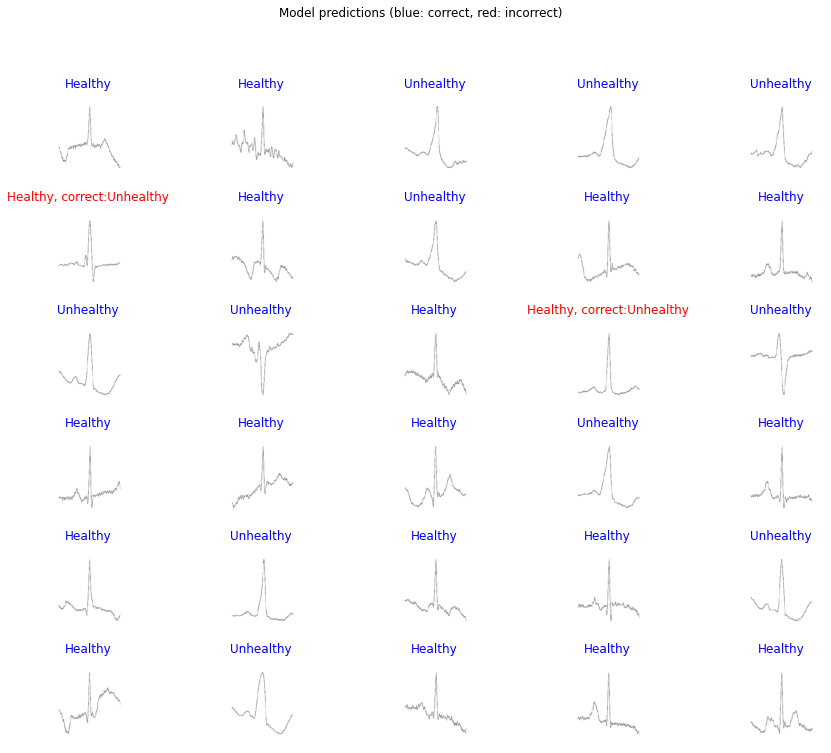

In [11]:
# get a random batch of images
image_batch, label_batch = next(iter(validation_generator))
# turn the original labels into human-readable text
label_batch = [CLASS_NAMES[np.argmax(label_batch[i])] for i in range(batch_size)]
# predict the images on the model
predicted_class_names = model.predict(image_batch)
predicted_ids = [np.argmax(predicted_class_names[i]) for i in range(batch_size)]
# turn the predicted vectors to human readable labels
predicted_class_names = np.array([CLASS_NAMES[id] for id in predicted_ids])
# some nice plotting
plt.figure(figsize=(15,12))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    if predicted_class_names[n] == label_batch[n]:
        color = "blue"
        title = predicted_class_names[n].title()
    else:
        color = "red"
        title = f"{predicted_class_names[n].title()}, correct:{label_batch[n]}"
    plt.title(title, color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")
plt.show()
